In [ ]:
!wget https://storage.googleapis.com/quickdraw_dataset/sketchrnn/cat.npz

In [1]:
!pip install einops

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install cairosvg

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.5 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip install svgwrite

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [70]:
import math
from typing import Optional, Tuple, Any

import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch import optim
from torch.utils.data import Dataset, DataLoader

import einops

from PIL import Image
import cairosvg
import os
from six.moves import range
import svgwrite
import io
import tensorflow as tf
import torch.nn.functional as F

In [71]:
def get_bounds(data, factor=10):
    """Return bounds of data."""
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return min_x, max_x, min_y, max_y

In [72]:
def get_max_len(strokes):
    """Return the maximum length of an array of strokes."""
    max_len = 0
    for stroke in strokes:  # stroke: [N_points, 3]
        ml = len(stroke)
        max_len = ml if ml > max_len else max_len

    return max_len

In [73]:
def draw_strokes(data, svg_filename, factor=0.2, padding=50):
    """
    little function that displays vector images and saves them to .svg
    :param data:
    :param factor:
    :param svg_filename:
    :param padding:
    :return:
    """
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (padding + max_x - min_x, padding + max_y - min_y)
    dwg = svgwrite.Drawing(size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))
    lift_pen = 1
    abs_x = int(padding / 2) - min_x
    abs_y = int(padding / 2) - min_y
    p = "M%s, %s " % (abs_x, abs_y)
    # use lowcase for relative position
    command = "m"

    for i in range(len(data)):
        if lift_pen == 1:
            command = "m"
        elif command != "l":
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + ", " + str(y) + " "
    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))
    #dwg.save()

    svg_code = dwg.tostring()
    img = cairosvg.svg2png(bytestring=svg_code)
    image = Image.open(io.BytesIO(img))
    image = image.resize((48,48))
    #image = image.convert('1')
    aarr = np.asarray(image)
    aarr = np.where(aarr < 255, 0, 255)
    aarr = aarr[:,:,1]
    # aarr = np.reshape(aarr, (28*28))
    # np.save('array', aarr)
    #image.save(svg_filename + '.png')
    return dims, dwg.tostring(), aarr

In [104]:
def load_dataset(data_dir, data_set):
    """Loads the .npz file, and splits the set into train/valid/test."""

    # normalizes the x and y columns using the training set.
    # applies same scaling factor to valid and test set.
    img_H, img_W = 48, 48

    percentage = 0.2

    if isinstance(data_set, list):
        datasets = data_set
    else:
        datasets = [data_set]

    train_strokes = None
    valid_strokes = None
    test_strokes = None

    png_paths_map = {'train': [], 'valid': [], 'test': []}

    for dataset in datasets:
        data_filepath = os.path.join(data_dir, 'npz', dataset)
        data = np.load(data_filepath, encoding='latin1', allow_pickle=True)
        print('Loaded {}/{}/{} from {}'.format(
            len(data['train']), len(data['valid']), len(data['test']),
            dataset))
        if train_strokes is None:
            train_strokes = data['train'][:int(len(data['train']) * percentage)]  # [N (#sketches),], each with [S (#points), 3]
            valid_strokes = data['valid'][:int(len(data['valid']) * percentage)] 
            test_strokes = data['test'][:int(len(data['test']) * percentage)] 
        else:
            train_strokes = np.concatenate((train_strokes, data['train'][:int(len(data['train']) * percentage)] ))
            valid_strokes = np.concatenate((valid_strokes, data['valid'][:int(len(data['valid']) * percentage)] ))
            test_strokes = np.concatenate((test_strokes, data['test'][:int(len(data['test']) * percentage)] ))

        splits = ['train', 'valid', 'test']
        for split in splits:
            for im_idx in range(len(data[split][:int(len(data[split]) * percentage)] ) ):
                png_path = os.path.join(data_dir, 'png', dataset[:-4], split,
                                        str(img_H) + 'x' + str(img_W), str(im_idx) + '.png')
                png_paths_map[split].append(png_path)

    all_strokes = np.concatenate((train_strokes, valid_strokes, test_strokes))
    num_points = 0
    for stroke in all_strokes:
        num_points += len(stroke)
    avg_len = num_points / len(all_strokes)
    print('Dataset combined: {} ({}/{}/{}), avg len {}'.format(
        len(all_strokes), len(train_strokes), len(valid_strokes),
        len(test_strokes), int(avg_len)))
    assert len(train_strokes) == len(png_paths_map['train'])
    assert len(valid_strokes) == len(png_paths_map['valid'])
    assert len(test_strokes) == len(png_paths_map['test'])

    # calculate the max strokes we need.
    max_seq_len = get_max_len(all_strokes)

    result = {'train':train_strokes, 'valid': valid_strokes, 'test': test_strokes}
    png_paths = {'train':png_paths_map['train'], 'valid':png_paths_map['valid'], 'test':png_paths_map['test']}
    return result, png_paths

In [75]:
def pad_image(png_filename, pngsize):
    curr_png = Image.open(png_filename).convert('RGB')
    png_curr_w = curr_png.width
    png_curr_h = curr_png.height
    print("pngsize: {}, {}".format(pngsize[0],pngsize[1]))

    if png_curr_w != pngsize[0] and png_curr_h != pngsize[1]:
        print('Not aligned', 'png_curr_w', png_curr_w, 'png_curr_h', png_curr_h)

    padded_png = np.zeros(shape=[pngsize[1], pngsize[0], 3], dtype=np.uint8)
    padded_png.fill(255)

    if png_curr_w > png_curr_h:
        pad = int(round((png_curr_w - png_curr_h) / 2))
        padded_png[pad: pad + png_curr_h, :png_curr_w, :] = np.array(curr_png, dtype=np.uint8)
    else:
        pad = int(round((png_curr_h - png_curr_w) / 2))
        padded_png[:png_curr_h, pad: pad + png_curr_w, :] = np.array(curr_png, dtype=np.uint8)

    padded_png = Image.fromarray(padded_png, 'RGB')
    padded_png.save(png_filename, 'PNG')

In [76]:
def svg2png(dwg_string, svgsize, pngsize, png_filename, padding=False):
    """convert svg into png, using cairosvg"""
    svg_w, svg_h = svgsize
    png_w, png_h = pngsize
    x_scale = png_w / svg_w
    y_scale = png_h / svg_h

    if x_scale > y_scale:
        cairosvg.svg2png(bytestring=dwg_string, write_to=png_filename, output_height=png_h)
    else:
        cairosvg.svg2png(bytestring=dwg_string, write_to=png_filename, output_width=png_w)

    if padding:
        pad_image(png_filename, pngsize)
    img = Image.open(png_filename)
    img = img.resize((48,48))
    img = np.asarray(img)
    img = np.where(img < 254, 0, 255).astype(np.uint8)
    #plt.imshow(img)
    img = Image.fromarray(img)
    img.save(png_filename, 'PNG')

In [77]:
def render_svg2bitmap(data_base_dir, data_set):
    img_H, img_W = 250, 250

    npz_dir = os.path.join(data_base_dir, 'npz')
    svg_dir = os.path.join(data_base_dir, 'svg')
    png_dir = os.path.join(data_base_dir, 'png')

    #model_params = sketch_rnn_model.get_default_hparams()
    
    for dataset_i in range(len(data_set)):
        assert data_set[dataset_i][-4:] == '.npz'
        cate_svg_dir = os.path.join(svg_dir, data_set[dataset_i][:-4])
        cate_png_dir = os.path.join(png_dir, data_set[dataset_i][:-4])

        datasets, png_paths = load_dataset(data_base_dir, data_set)

        data_types = ['train', 'valid', 'test']
        for data_type in data_types:
            split_cate_svg_dir = os.path.join(cate_svg_dir, data_type)
            split_cate_png_dir = os.path.join(cate_png_dir, data_type,
                                              str(48) + 'x' + str(48))

            os.makedirs(split_cate_svg_dir, exist_ok=True)
            os.makedirs(split_cate_png_dir, exist_ok=True)

            split_dataset = datasets[data_type]

            for ex_idx in range(len(split_dataset)):
                stroke = np.copy(split_dataset[ex_idx])
                print('example_idx', ex_idx, 'stroke.shape', stroke.shape)

                png_path = png_paths[data_type][ex_idx]
                # print("HOHOHO")
                # print(split_cate_png_dir)
                # print(png_path[:len(split_cate_png_dir)])
                # assert split_cate_png_dir == png_path[:len(split_cate_png_dir)]
                actual_idx = png_path[len(split_cate_png_dir) + 1:-4]
                svg_path = os.path.join(split_cate_svg_dir, str(actual_idx) + '.svg')

                svg_size, dwg_bytestring, aarr = draw_strokes(stroke, svg_path, padding=10)  # (w, h)
                svg2png(dwg_bytestring, svg_size, (img_W, img_H), png_path,
                               padding=True)
                
#render_svg2bitmap('./', ['cat.npz'])

In [79]:
"""
import matplotlib.pyplot as plt
datasets, png_paths = load_dataset('./', ['cat.npz'])
stroke = np.copy(datasets['train'][0])
svg_size, dwg_bytestring, aarr = draw_strokes(stroke, './', padding=10)
#cairosvg.svg2png(bytestring=dwg_bytestring, write_to='./cat.png')

#svg2png(dwg_bytestring, svg_size, (250, 250), './cat.png',padding=True)
#print(png_paths['train'][0])
#print(aarr.shape)
#plt.imshow(aarr)
"""

"\nimport matplotlib.pyplot as plt\ndatasets, png_paths = load_dataset('./', ['cat.npz'])\nstroke = np.copy(datasets['train'][0])\nsvg_size, dwg_bytestring, aarr = draw_strokes(stroke, './', padding=10)\n#cairosvg.svg2png(bytestring=dwg_bytestring, write_to='./cat.png')\n\n#svg2png(dwg_bytestring, svg_size, (250, 250), './cat.png',padding=True)\n#print(png_paths['train'][0])\n#print(aarr.shape)\n#plt.imshow(aarr)\n"

In [93]:
class StrokesDataset(Dataset):
    """
    ## Dataset
    This class loads and pre-processes the data.
    """

    def __init__(self, dataset: np.array, max_seq_length: int, png_paths:list, scale: Optional[float] = None):
        """
        `dataset` is a list of numpy arrays of shape [seq_len, 3].
        It is a sequence of strokes, and each stroke is represented by
        3 integers.
        First two are the displacements along x and y ($\Delta x$, $\Delta y$)
        and the last integer represents the state of the pen, $1$ if it's touching
        the paper and $0$ otherwise.
        """
        data = []
        # We iterate through each of the sequences and filter
        for seq in dataset:
            # Filter if the length of the sequence of strokes is within our range
            if 10 < len(seq) <= max_seq_length:
                # Clamp $\Delta x$, $\Delta y$ to $[-1000, 1000]$
                seq = np.minimum(seq, 1000)
                seq = np.maximum(seq, -1000)
                # Convert to a floating point array and add to `data`
                seq = np.array(seq, dtype=np.float32)
                data.append(seq)

        # We then calculate the scaling factor which is the
        # standard deviation of ($\Delta x$, $\Delta y$) combined.
        # Paper notes that the mean is not adjusted for simplicity,
        # since the mean is anyway close to $0$.
        if scale is None:
            scale = np.std(np.concatenate([np.ravel(s[:, 0:2]) for s in data]))
        self.scale = scale

        # Get the longest sequence length among all sequences
        longest_seq_len = max([len(seq) for seq in data])

        # We initialize PyTorch data array with two extra steps for start-of-sequence (sos)
        # and end-of-sequence (eos).
        # Each step is a vector $(\Delta x, \Delta y, p_1, p_2, p_3)$.
        # Only one of $p_1, p_2, p_3$ is $1$ and the others are $0$.
        # They represent *pen down*, *pen up* and *end-of-sequence* in that order.
        # $p_1$ is $1$ if the pen touches the paper in the next step.
        # $p_2$ is $1$ if the pen doesn't touch the paper in the next step.
        # $p_3$ is $1$ if it is the end of the drawing.
        self.data = torch.zeros(len(data), longest_seq_len + 2, 5, dtype=torch.float)
        # The mask array needs only one extra-step since it is for the outputs of the
        # decoder, which takes in `data[:-1]` and predicts next step.
        self.mask = torch.zeros(len(data), longest_seq_len + 1)

        for i, seq in enumerate(data):
            seq = torch.from_numpy(seq)
            len_seq = len(seq)
            # Scale and set $\Delta x, \Delta y$
            self.data[i, 1:len_seq + 1, :2] = seq[:, :2] / scale
            # $p_1$
            self.data[i, 1:len_seq + 1, 2] = 1 - seq[:, 2]
            # $p_2$
            self.data[i, 1:len_seq + 1, 3] = seq[:, 2]
            # $p_3$
            self.data[i, len_seq + 1:, 4] = 1
            # Mask is on until end of sequence
            self.mask[i, :len_seq + 1] = 1

        # Start-of-sequence is $(0, 0, 1, 0, 0)$
        self.data[:, 0, 2] = 1

        self.png_paths = png_paths

    def __len__(self):
        """Size of the dataset"""
        return len(self.data)

    def __getitem__(self, idx: int):
        """Get a sample"""
        img = Image.open(self.png_paths[idx]).convert('L')
        img = np.array(img)
        return self.data[idx], self.mask[idx], img

Loaded 70000/2500/2500 from cat.npz
Loaded 70000/2500/2500 from duck.npz
Dataset combined: 15000 (14000/500/500), avg len 66
(48, 48)


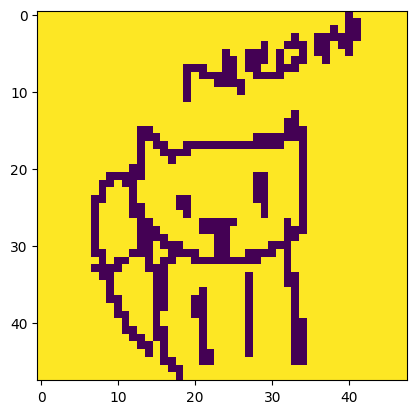

In [103]:
"""
data_sets = ['cat.npz', 'duck.npz']
datasets, png_paths = load_dataset('./', data_sets)
max_seq_length = 150
# Create training dataset
train_dataset = StrokesDataset(datasets['train'], max_seq_length, png_paths['train'])
_,_, img = train_dataset[0]
print(img.shape)
plt.imshow(img)
"""

In [81]:
class BivariateGaussianMixture:
    """
    ## Bi-variate Gaussian mixture
    The mixture is represented by $\Pi$ and
    $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$.
    This class adjusts temperatures and creates the categorical and Gaussian
    distributions from the parameters.
    """

    def __init__(self, pi_logits: torch.Tensor, mu_x: torch.Tensor, mu_y: torch.Tensor,
                 sigma_x: torch.Tensor, sigma_y: torch.Tensor, rho_xy: torch.Tensor):
        self.pi_logits = pi_logits
        self.mu_x = mu_x
        self.mu_y = mu_y
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.rho_xy = rho_xy

    @property
    def n_distributions(self):
        """Number of distributions in the mixture, $M$"""
        return self.pi_logits.shape[-1]

    def set_temperature(self, temperature: float):
        """
        Adjust by temperature $\tau$
        """
        # $$\hat{\Pi_k} \leftarrow \frac{\hat{\Pi_k}}{\tau}$$
        self.pi_logits /= temperature
        # $$\sigma^2_x \leftarrow \sigma^2_x \tau$$
        self.sigma_x *= math.sqrt(temperature)
        # $$\sigma^2_y \leftarrow \sigma^2_y \tau$$
        self.sigma_y *= math.sqrt(temperature)

    def get_distribution(self):
        # Clamp $\sigma_x$, $\sigma_y$ and $\rho_{xy}$ to avoid getting `NaN`s
        sigma_x = torch.clamp_min(self.sigma_x, 1e-5)
        sigma_y = torch.clamp_min(self.sigma_y, 1e-5)
        rho_xy = torch.clamp(self.rho_xy, -1 + 1e-5, 1 - 1e-5)

        # Get means
        mean = torch.stack([self.mu_x, self.mu_y], -1)
        # Get covariance matrix
        cov = torch.stack([
            sigma_x * sigma_x, rho_xy * sigma_x * sigma_y,
            rho_xy * sigma_x * sigma_y, sigma_y * sigma_y
        ], -1)
        cov = cov.view(*sigma_y.shape, 2, 2)

        # Create bi-variate normal distribution.
        #
        # 📝 It would be efficient to `scale_tril` matrix as `[[a, 0], [b, c]]`
        # where
        # $$a = \sigma_x, b = \rho_{xy} \sigma_y, c = \sigma_y \sqrt{1 - \rho^2_{xy}}$$.
        # But for simplicity we use co-variance matrix.
        # [This is a good resource](https://www2.stat.duke.edu/courses/Spring12/sta104.1/Lectures/Lec22.pdf)
        # if you want to read up more about bi-variate distributions, their co-variance matrix,
        # and probability density function.
        multi_dist = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)

        # Create categorical distribution $\Pi$ from logits
        cat_dist = torch.distributions.Categorical(logits=self.pi_logits)

        #
        return cat_dist, multi_dist

In [82]:
class EncoderRNN(nn.Module):
    """
    ## Encoder module
    This consists of a bidirectional LSTM
    """

    def __init__(self, d_z: int):
        super().__init__()
        # Create a bidirectional LSTM taking a sequence of
        # $(\Delta x, \Delta y, p_1, p_2, p_3)$ as input.
        self.filter_hp = torch.tensor([[[[-1, -1, -1],
                                             [-1, 8, -1],
                                             [-1, -1, -1]]]]).float()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels= 4, kernel_size = 2, stride =2)
        self.conv2 = nn.Conv2d(in_channels = 4, out_channels= 4, kernel_size = 2, stride =1)
        self.conv3 = nn.Conv2d(in_channels = 4, out_channels= 8, kernel_size = 2, stride =2)
        self.conv4 = nn.Conv2d(in_channels = 8, out_channels= 8, kernel_size = 2, stride =1)
        self.conv5 = nn.Conv2d(in_channels = 8, out_channels= 8, kernel_size = 2, stride =2)
        self.conv6 = nn.Conv2d(in_channels = 8, out_channels= 8, kernel_size = 2, stride =1)

        # Head to get $\mu$
        self.mu_head = nn.Linear(128, d_z)
        # Head to get $\hat{\sigma}$
        self.sigma_head = nn.Linear(128, d_z)

    def high_pass_filtering(self, img_in):
        """
        high pass filtering
        :param img_in: [N, H, W, 1]
        :return: img_out: [N, H, W, 1]
        """
        img_out = F.conv2d(img_in, self.filter_hp)
        return img_out


    def forward(self, inputs: torch.Tensor, state=None):
        x = self.high_pass_filtering(inputs)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.tanh(self.conv6(x))
        
        x = x.view(inputs.shape[0], -1)

        # $\mu$
        mu = self.mu_head(x)
        # $\hat{\sigma}$
        sigma_hat = self.sigma_head(x)
        # $\sigma = \exp(\frac{\hat{\sigma}}{2})$
        sigma = torch.exp(sigma_hat / 2.)

        # Sample $z = \mu + \sigma \cdot \mathcal{N}(0, I)$
        z = mu + sigma * torch.normal(mu.new_zeros(mu.shape), mu.new_ones(mu.shape))
      
        return z, mu, sigma_hat

In [83]:
"""
test_array = torch.rand((2,1 ,48,48))
encoder = EncoderRNN(128)
encoder(test_array)
"""

'\ntest_array = torch.rand((2,1 ,48,48))\nencoder = EncoderRNN(128)\nencoder(test_array)\n'

In [84]:
class DecoderRNN(nn.Module):
    """
    ## Decoder module
    This consists of a LSTM
    """

    def __init__(self, d_z: int, dec_hidden_size: int, n_distributions: int):
        super().__init__()
        # LSTM takes $[(\Delta x, \Delta y, p_1, p_2, p_3); z]$ as input
        self.lstm = nn.LSTM(d_z + 5, dec_hidden_size)

        # Initial state of the LSTM is $[h_0; c_0] = \tanh(W_{z}z + b_z)$.
        # `init_state` is the linear transformation for this
        self.init_state = nn.Linear(d_z, 2 * dec_hidden_size)

        # This layer produces outputs for each of the `n_distributions`.
        # Each distribution needs six parameters
        # $(\hat{\Pi_i}, \mu_{x_i}, \mu_{y_i}, \hat{\sigma_{x_i}}, \hat{\sigma_{y_i}} \hat{\rho_{xy_i}})$
        self.mixtures = nn.Linear(dec_hidden_size, 6 * n_distributions)

        # This head is for the logits $(\hat{q_1}, \hat{q_2}, \hat{q_3})$
        self.q_head = nn.Linear(dec_hidden_size, 3)
        # This is to calculate $\log(q_k)$ where
        # $$q_k = \operatorname{softmax}(\hat{q})_k = \frac{\exp(\hat{q_k})}{\sum_{j = 1}^3 \exp(\hat{q_j})}$$
        self.q_log_softmax = nn.LogSoftmax(-1)

        # These parameters are stored for future reference
        self.n_distributions = n_distributions
        self.dec_hidden_size = dec_hidden_size

    def forward(self, x: torch.Tensor, z: torch.Tensor, stroke: Optional[torch.Tensor], max_seq_len: Optional[int], state: Optional[Tuple[torch.Tensor, torch.Tensor]]):
        # The target/expected vectors of strokes
        #self.output_x = self.input_data[:, 1:self.hps.max_seq_len + 1, :]  # [N, max_seq_len, 5]
        # vectors of strokes to be fed to decoder (same as above, but lagged behind
        # one step to include initial dummy value of (0, 0, 1, 0, 0))
        #self.input_x = self.input_data[:, :self.hps.max_seq_len, :]  # [N, max_seq_len, 5]

        # Calculate the initial state
        if state is None:
            # $[h_0; c_0] = \tanh(W_{z}z + b_z)$
            h, c = torch.split(torch.tanh(self.init_state(z)), self.dec_hidden_size, 1)
            # `h` and `c` have shapes `[batch_size, lstm_size]`. We want to shape them
            # to `[1, batch_size, lstm_size]` because that's the shape used in LSTM.
            state = (h.unsqueeze(0).contiguous(), c.unsqueeze(0).contiguous())
            #state = torch.cat(state, stroke)

        # Run the LSTM
        outputs, state = self.lstm(x, state)

        # Get $\log(q)$
        q_logits = self.q_log_softmax(self.q_head(outputs))

        # Get $(\hat{\Pi_i}, \mu_{x,i}, \mu_{y,i}, \hat{\sigma_{x,i}},
        # \hat{\sigma_{y,i}} \hat{\rho_{xy,i}})$.
        # `torch.split` splits the output into 6 tensors of size `self.n_distribution`
        # across dimension `2`.
        pi_logits, mu_x, mu_y, sigma_x, sigma_y, rho_xy = \
            torch.split(self.mixtures(outputs), self.n_distributions, 2)

        # Create a bi-variate Gaussian mixture
        # $\Pi$ and 
        # $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$
        # where
        # $$\sigma_{x,i} = \exp(\hat{\sigma_{x,i}}), \sigma_{y,i} = \exp(\hat{\sigma_{y,i}}),
        # \rho_{xy,i} = \tanh(\hat{\rho_{xy,i}})$$
        # and
        # $$\Pi_i = \operatorname{softmax}(\hat{\Pi})_i = \frac{\exp(\hat{\Pi_i})}{\sum_{j = 1}^3 \exp(\hat{\Pi_j})}$$
        #
        # $\Pi$ is the categorical probabilities of choosing the distribution out of the mixture
        # $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$.
        dist = BivariateGaussianMixture(pi_logits, mu_x, mu_y,
                                        torch.exp(sigma_x), torch.exp(sigma_y), torch.tanh(rho_xy))

        #
        return dist, q_logits, state

In [85]:
"""
batchSize= 3
test_array = torch.rand((batchSize,1 ,48,48))
encoder = EncoderRNN(128)
z, mu, sigma_hat = encoder(test_array)
print(z.shape)
# Decode the mixture of distributions and $\hat{q}$
strokes_array = torch.rand(96, batchSize, 5)
print(strokes_array.shape)
# Concatenate $[(\Delta x, \Delta y, p_1, p_2, p_3); z]$
z_stack = z.unsqueeze(0).expand(strokes_array.shape[0] - 1, -1, -1)
print(z_stack.shape)
inputs = torch.cat([strokes_array[:-1], z_stack], 2)

decoder = DecoderRNN(128, 512, 20)
dist, q_logits, _ = decoder(inputs, z, 0, None, None)
print(dist)
"""

'\nbatchSize= 3\ntest_array = torch.rand((batchSize,1 ,48,48))\nencoder = EncoderRNN(128)\nz, mu, sigma_hat = encoder(test_array)\nprint(z.shape)\n# Decode the mixture of distributions and $\\hat{q}$\nstrokes_array = torch.rand(96, batchSize, 5)\nprint(strokes_array.shape)\n# Concatenate $[(\\Delta x, \\Delta y, p_1, p_2, p_3); z]$\nz_stack = z.unsqueeze(0).expand(strokes_array.shape[0] - 1, -1, -1)\nprint(z_stack.shape)\ninputs = torch.cat([strokes_array[:-1], z_stack], 2)\n\ndecoder = DecoderRNN(128, 512, 20)\ndist, q_logits, _ = decoder(inputs, z, 0, None, None)\nprint(dist)\n'

In [86]:
class ReconstructionLoss(nn.Module):
    """
    ## Reconstruction Loss
    """

    def forward(self, mask: torch.Tensor, target: torch.Tensor,
                 dist: 'BivariateGaussianMixture', q_logits: torch.Tensor):
        # Get $\Pi$ and $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$
        pi, mix = dist.get_distribution()
        # `target` has shape `[seq_len, batch_size, 5]` where the last dimension is the features
        # $(\Delta x, \Delta y, p_1, p_2, p_3)$.
        # We want to get $\Delta x, \Delta$ y and get the probabilities from each of the distributions
        # in the mixture $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$.
        #
        # `xy` will have shape `[seq_len, batch_size, n_distributions, 2]`
        xy = target[:, :, 0:2].unsqueeze(-2).expand(-1, -1, dist.n_distributions, -1)
        # Calculate the probabilities
        # $$p(\Delta x, \Delta y) =
        # \sum_{j=1}^M \Pi_j \mathcal{N} \big( \Delta x, \Delta y \vert
        # \mu_{x,j}, \mu_{y,j}, \sigma_{x,j}, \sigma_{y,j}, \rho_{xy,j}
        # \big)$$
        probs = torch.sum(pi.probs * torch.exp(mix.log_prob(xy)), 2)

        # $$L_s = - \frac{1}{N_{max}} \sum_{i=1}^{N_s} \log \big (p(\Delta x, \Delta y) \big)$$
        # Although `probs` has $N_{max}$ (`longest_seq_len`) elements, the sum is only taken
        # upto $N_s$ because the rest is masked out.
        #
        # It might feel like we should be taking the sum and dividing by $N_s$ and not $N_{max}$,
        # but this will give higher weight for individual predictions in shorter sequences.
        # We give equal weight to each prediction $p(\Delta x, \Delta y)$ when we divide by $N_{max}$
        loss_stroke = -torch.mean(mask * torch.log(1e-5 + probs))

        # $$L_p = - \frac{1}{N_{max}} \sum_{i=1}^{N_{max}} \sum_{k=1}^{3} p_{k,i} \log(q_{k,i})$$
        loss_pen = -torch.mean(target[:, :, 2:] * q_logits)

        # $$L_R = L_s + L_p$$
        return loss_stroke + loss_pen


In [87]:
class KLDivLoss(nn.Module):
    """
    ## KL-Divergence loss
    This calculates the KL divergence between a given normal distribution and $\mathcal{N}(0, 1)$
    """

    def forward(self, sigma_hat: torch.Tensor, mu: torch.Tensor):
        # $$L_{KL} = - \frac{1}{2 N_z} \bigg( 1 + \hat{\sigma} - \mu^2 - \exp(\hat{\sigma}) \bigg)$$
        return -0.5 * torch.mean(1 + sigma_hat - mu ** 2 - torch.exp(sigma_hat))


In [88]:
class Sampler:
    """
    ## Sampler
    This samples a sketch from the decoder and plots it
    """

    def __init__(self, encoder: EncoderRNN, decoder: DecoderRNN):
        self.decoder = decoder
        self.encoder = encoder

    def sample(self, data: torch.Tensor, temperature: float):
        # $N_{max}$
        longest_seq_len = len(data)

        # Get $z$ from the encoder
        z, _, _ = self.encoder(data)

        # Start-of-sequence stroke is $(0, 0, 1, 0, 0)$
        s = data.new_tensor([0, 0, 1, 0, 0])
        seq = [s]
        # Initial decoder is `None`.
        # The decoder will initialize it to $[h_0; c_0] = \tanh(W_{z}z + b_z)$
        state = None

        # We don't need gradients
        with torch.no_grad():
            # Sample $N_{max}$ strokes
            for i in range(longest_seq_len):
                # $[(\Delta x, \Delta y, p_1, p_2, p_3); z]$ is the input to the decoder
                data = torch.cat([s.view(1, 1, -1), z.unsqueeze(0)], 2)
                # Get $\Pi$, $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$,
                # $q$ and the next state from the decoder
                dist, q_logits, state = self.decoder(data, z, state)
                # Sample a stroke
                s = self._sample_step(dist, q_logits, temperature)
                # Add the new stroke to the sequence of strokes
                seq.append(s)
                # Stop sampling if $p_3 = 1$. This indicates that sketching has stopped
                if s[4] == 1:
                    break

        # Create a PyTorch tensor of the sequence of strokes
        seq = torch.stack(seq)

        # Plot the sequence of strokes
        self.plot(seq)

    @staticmethod
    def _sample_step(dist: 'BivariateGaussianMixture', q_logits: torch.Tensor, temperature: float):
        # Set temperature $\tau$ for sampling. This is implemented in class `BivariateGaussianMixture`.
        dist.set_temperature(temperature)
        # Get temperature adjusted $\Pi$ and $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$
        pi, mix = dist.get_distribution()
        # Sample from $\Pi$ the index of the distribution to use from the mixture
        idx = pi.sample()[0, 0]

        # Create categorical distribution $q$ with log-probabilities `q_logits` or $\hat{q}$
        q = torch.distributions.Categorical(logits=q_logits / temperature)
        # Sample from $q$
        q_idx = q.sample()[0, 0]

        # Sample from the normal distributions in the mixture and pick the one indexed by `idx`
        xy = mix.sample()[0, 0, idx]

        # Create an empty stroke $(\Delta x, \Delta y, q_1, q_2, q_3)$
        stroke = q_logits.new_zeros(5)
        # Set $\Delta x, \Delta y$
        stroke[:2] = xy
        # Set $q_1, q_2, q_3$
        stroke[q_idx + 2] = 1
        #
        return stroke

    @staticmethod
    def plot(seq: torch.Tensor):
        # Take the cumulative sums of $(\Delta x, \Delta y)$ to get $(x, y)$
        seq[:, 0:2] = torch.cumsum(seq[:, 0:2], dim=0)
        # Create a new numpy array of the form $(x, y, q_2)$
        seq[:, 2] = seq[:, 3]
        seq = seq[:, 0:3].detach().cpu().numpy()

        # Split the array at points where $q_2$ is $1$.
        # i.e. split the array of strokes at the points where the pen is lifted from the paper.
        # This gives a list of sequence of strokes.
        strokes = np.split(seq, np.where(seq[:, 2] > 0)[0] + 1)
        # Plot each sequence of strokes
        for s in strokes:
            plt.plot(s[:, 0], -s[:, 1])
        # Don't show axes
        plt.axis('off')
        # Show the plot
        plt.show()

In [106]:
class Configs():
    """
    ## Configurations
    These are default configurations which can later be adjusted by passing a `dict`.
    """

    # Device configurations to pick the device to run the experiment
    #device: torch.device = DeviceConfigs()
    #
    encoder: EncoderRNN
    decoder: DecoderRNN
    optimizer: optim.Adam
    sampler: Sampler

    dataset_name: str
    train_loader: DataLoader
    valid_loader: DataLoader
    train_dataset: StrokesDataset
    valid_dataset: StrokesDataset

    # Encoder and decoder sizes
    enc_hidden_size = 256
    dec_hidden_size = 512

    # Batch size
    batch_size = 100

    # Number of features in $z$
    d_z = 128
    # Number of distributions in the mixture, $M$
    n_distributions = 20

    # Weight of KL divergence loss, $w_{KL}$
    #kl_div_loss_weight = 0.5
    # Gradient clipping
    grad_clip = 1.
    # Temperature $\tau$ for sampling
    temperature = 0.4

    # Filter out stroke sequences longer than $200$
    max_seq_length = 200

    epochs = 100

    #kl_div_loss = KLDivLoss()
    reconstruction_loss = ReconstructionLoss()

    def __init__(self):
        self.device = 'cpu'
        # Initialize encoder & decoder
        self.encoder = EncoderRNN(self.d_z).to(self.device)
        self.decoder = DecoderRNN(self.d_z, self.dec_hidden_size, self.n_distributions).to(self.device)

        # Set optimizer. Things like type of optimizer and learning rate are configurable
        #optimizer = OptimizerConfigs()
        #optimizer.parameters = list(self.encoder.parameters()) + list(self.decoder.parameters())
        #self.optimizer = optimizer
        self.optimizer = optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=0.0001)

        # Create sampler
        self.sampler = Sampler(self.encoder, self.decoder)

        # `npz` file path is `data/sketch/[DATASET NAME].npz`
        data_sets = ['cat.npz', 'duck.npz', 'owl.npz', 'giraffe.npz']
        datasets, png_paths = load_dataset('./', data_sets)
        if not os.path.exists(png_paths['train'][-1]): #TODO change condition
            render_svg2bitmap('./', data_sets)

        # Create training dataset
        self.train_dataset = StrokesDataset(datasets['train'], self.max_seq_length, png_paths['train'])
        # Create validation dataset
        self.valid_dataset = StrokesDataset(datasets['valid'], self.max_seq_length, png_paths['valid'], self.train_dataset.scale)

        # Create training data loader
        self.train_loader = DataLoader(self.train_dataset, self.batch_size, shuffle=True)
        # Create validation data loader
        self.valid_loader = DataLoader(self.valid_dataset, self.batch_size)

        self.state_modules = []

    def step(self, batch: Any, is_train=True):
        self.encoder.train(is_train)
        self.decoder.train(is_train)

        # Move `data` and `mask` to device and swap the sequence and batch dimensions.
        # `data` will have shape `[seq_len, batch_size, 5]` and
        # `mask` will have shape `[seq_len, batch_size]`.
        data = batch[0].to(self.device).transpose(0, 1)
        mask = batch[1].to(self.device).transpose(0, 1)
        img = batch[2].to(self.device).transpose(0,1)



        z, mu, sigma_hat = self.encoder(img)

        # Decode the mixture of distributions and $\hat{q}$

        # Concatenate $[(\Delta x, \Delta y, p_1, p_2, p_3); z]$
        z_stack = z.unsqueeze(0).expand(data.shape[0] - 1, -1, -1)
        inputs = torch.cat([data[:-1], z_stack], 2)
        # Get mixture of distributions and $\hat{q}$
        dist, q_logits, _ = self.decoder(inputs, z, None)

        # Compute the loss
        # $L_{KL}$
        #kl_loss = self.kl_div_loss(sigma_hat, mu)
        # $L_R$
        reconstruction_loss = self.reconstruction_loss(mask, data[1:], dist, q_logits)
        # $Loss = L_R + w_{KL} L_{KL}$
        loss = reconstruction_loss # + self.kl_div_loss_weight * kl_loss



        # Only if we are in training state
        if is_train:

            # Set `grad` to zero
            self.optimizer.zero_grad()
            # Compute gradients
            loss.backward()
            #print(loss.item())
            # Clip gradients
            nn.utils.clip_grad_norm_(self.encoder.parameters(), self.grad_clip)
            nn.utils.clip_grad_norm_(self.decoder.parameters(), self.grad_clip)
            # Optimize
            self.optimizer.step()


    def sample(self):
        # Randomly pick a sample from validation dataset to encoder
        data, *_ = self.valid_dataset[np.random.choice(len(self.valid_dataset))]
        # Add batch dimension and move it to device
        data = data.unsqueeze(1).to(self.device)
        # Sample
        self.sampler.sample(data, self.temperature)

In [90]:
c = Configs()

Loaded 70000/2500/2500 from cat.npz
Dataset combined: 75000 (70000/2500/2500), avg len 69
Loaded 70000/2500/2500 from cat.npz
Dataset combined: 75000 (70000/2500/2500), avg len 69
example_idx 0 stroke.shape (96, 3)
pngsize: 250, 250
example_idx 1 stroke.shape (81, 3)
pngsize: 250, 250
example_idx 2 stroke.shape (76, 3)
pngsize: 250, 250
example_idx 3 stroke.shape (67, 3)
pngsize: 250, 250
example_idx 4 stroke.shape (47, 3)
pngsize: 250, 250
example_idx 5 stroke.shape (102, 3)
pngsize: 250, 250
example_idx 6 stroke.shape (81, 3)
pngsize: 250, 250
example_idx 7 stroke.shape (38, 3)
pngsize: 250, 250
example_idx 8 stroke.shape (60, 3)
pngsize: 250, 250
example_idx 9 stroke.shape (126, 3)
pngsize: 250, 250
example_idx 10 stroke.shape (92, 3)
pngsize: 250, 250
example_idx 11 stroke.shape (75, 3)
pngsize: 250, 250
example_idx 12 stroke.shape (71, 3)
pngsize: 250, 250
example_idx 13 stroke.shape (105, 3)
pngsize: 250, 250
example_idx 14 stroke.shape (84, 3)
pngsize: 250, 250
example_idx 15 st

Exception ignored from cffi callback <function _make_write_func.<locals>.write_func at 0x7f3dfdedb250>:
Traceback (most recent call last):
  File "/home/ndo001/.local/lib/python3.10/site-packages/cairocffi/surfaces.py", line 45, in write_func
    @ffi.callback("cairo_write_func_t", error=constants.STATUS_WRITE_ERROR)
KeyboardInterrupt: 


pngsize: 250, 250
example_idx 17320 stroke.shape (51, 3)
pngsize: 250, 250
example_idx 17321 stroke.shape (48, 3)


OSError: [Errno cairo returned CAIRO_STATUS_WRITE_ERROR: b'error while writing to output stream'] 11

In [ ]:
from tqdm import tqdm
epochs = 1

for i in range(epochs):
  for batch in tqdm(c.train_loader):
    c.step(batch)

In [ ]:

c.sample()

In [ ]:
torch.save(c.encoder.state_dict(), './encoder_weights')
torch.save(c.decoder.state_dict(), './decoder_weights')